# Baseball Homerun Predictions for Y2021

## Introduction

We are going to attempt to accurately predict the amount of homeruns that will occur for the MLB 2021 Season. Since the season has already been completed and thus all the homeruns that can occur in the 2021 season have already happened, we have a fine measurement as to just how accurate our model will be.

We are using data from the 2000-2020 seasons on players hitting stats organized by year. This dataset was obtained from http://www.seanlahman.com/baseball-archive/statistics/ using the 2020 - comma delimited version. This gives a mountain of different datasets, from which we pulled the Batting.csv dataset. The Batting.csv dataset had data on batters starting in the year 1871, which we have determined isn't exactly helpful when trying to determine more modern baseball statistics, thus our version of Batting.csv found at https://github.com/dswetlik/BaseballHRPrediction/blob/master/Batting.csv has been cut down from 1.5 centuries to 2 decades.

That being said, we need to clean up our dataset a little bit more before we begin. This is because we need to compare yearly overall statistics and not individual player data. We will combine all of the statistics from every year and then begin fitting that to models.

Our process for modeling will be fairly straightforward; we will do an ordinary least squares fit utilizing all of the predictors to get the p-values. After that, we will determine collinearity values using a VIF analysis. Then, we will perform subset selection using multiple techniques like forward subset selection. Finally, we will use that model to predict the amount of homeruns the next year and assess our accuracy.

An initial disclaimer, the 2020 season was drastically shorter than every other season in the dataset due to the global pandemic and therefore the sample size is much smaller. However, we expect that the decrease in homeruns and games played will also be reflected in the other predictors proportionately so that it can still be reliably used as data.

## Data Setup

In [1]:
# Basics and Plotting
import pandas as pd
import numpy as np
import scipy as scp
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import seaborn as sns
from itertools import chain, combinations

# Sklearn Models
import sklearn.linear_model as skl_lm
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.linear_model import Lasso, Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, LeaveOneOut, KFold, cross_val_score, cross_validate
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression

# Alternative models
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.formula.api as smf

In [2]:
baseball = pd.read_csv("https://raw.githubusercontent.com/dswetlik/BaseballHRPrediction/master/Batting.csv")

In [3]:
baseball

,playerID,yearID,stint,teamID,lgID,G,AB,R,H,2B,...,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP
0,abbotje01,2000,1,CHA,AL,80,215,31,59,15,...,29,2,1,21,38,1,2,2,1,2
1,abbotku01,2000,1,NYN,NL,79,157,22,34,7,...,12,1,1,14,51,2,1,0,1,2
2,abbotpa01,2000,1,SEA,AL,35,5,1,2,1,...,0,0,0,0,1,0,0,1,0,0
3,abreubo01,2000,1,PHI,NL,154,576,103,182,42,...,79,28,8,100,116,9,1,0,3,12
4,aceveju01,2000,1,MIL,NL,62,1,1,0,0,...,0,0,0,1,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29518,zimmebr02,2020,1,BAL,AL,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
29519,zimmejo02,2020,1,DET,AL,3,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
29520,zimmeky01,2020,1,KCA,AL,16,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
29521,zuberty01,2020,1,KCA,AL,23,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Below we are dropping the columns playerID, teamID, stint, and lgID, as we have decided that they would be inconsequential or irrelavent for determining league-wide homerun counts. This is because they are not even actual hitting statistics.

We are also going to drop CS, SH, SF, GIDP, SB, and HBP because they are stats related to groundouts/flyouts, at-bats that ended abruptly, and baserunning stats. Therefore, we determined that correlation would mean nothing because the stats have no real-life connection to homeruns and any connection would prove to be a spurious relationship.

In [4]:
baseball.drop(columns=["playerID","teamID","stint","lgID","CS","SH","SF","GIDP","SB","HBP"], axis=1, inplace=True)
baseball.rename(columns={"2B": "Double", "3B": "Triple"}, inplace=True)
baseball.head()

,yearID,G,AB,R,H,Double,Triple,HR,RBI,BB,SO,IBB
0,2000,80,215,31,59,15,1,3,29,21,38,1
1,2000,79,157,22,34,7,1,6,12,14,51,2
2,2000,35,5,1,2,1,0,0,0,0,1,0
3,2000,154,576,103,182,42,10,25,79,100,116,9
4,2000,62,1,1,0,0,0,0,0,1,1,0


After dropping those columns, the remaining columns are as follows:


| Num | ID     | Name                       |
|-----|--------|----------------------------|
|  0  | yearID | Year                       |
|  1  | G      | Games                      |
|  2  | AB     | At Bats                    |
|  3  | R      | Runs                       |
|  4  | H      | Hits                       |
|  5  | Double | Doubles                    |
|  6  | Triple | Triples                    |
|  7  | HR     | Homeruns                   |
|  8  | RBI    | Runs Batted In             |
|  9  | SB     | Stolen Bases               |
| 10  | CS     | Caught Stealing            |
| 11  | BB     | Base on Balls              |
| 12  | SO     | Strikeouts                 |
| 13  | IBB    | Intentional Walks          |
| 14  | HBP    | Hit By Pitch               |
| 15  | SH     | Sacrifice Hits             |
| 16  | SF     | Sacrifice Flies            |
| 17  | GIDP   | Grounded into Double Plays |

This is almost usable for what we want, but it is still organized per-player, and we want it to be based on the year's total statistics. We will go through and create a new dataset now based on years.

In [8]:
baseballYearTotal = []
for i in range(2000,2021):
    baseballYear = baseball.loc[baseball['yearID'] == i].to_dict(orient='dict')
    G = 0
    for j in baseballYear['G'].values():
        G += j
    AB = 0
    for j in baseballYear['AB'].values():
        AB += j
    R = 0
    for j in baseballYear['R'].values():
        R += j
    H = 0
    for j in baseballYear['H'].values():
        H += j
    Double = 0
    for j in baseballYear['Double'].values():
        Double += j
    Triple = 0
    for j in baseballYear['Triple'].values():
        Triple += j
    HR = 0
    for j in baseballYear['HR'].values():
        HR += j
    RBI = 0
    for j in baseballYear['RBI'].values():
        RBI += j
   # SB = 0
   # for j in baseballYear['SB'].values():
      #  SB += j
   # CS = 0
   # for j in baseballYear['CS'].values():
    #    CS += j
    BB = 0
    for j in baseballYear['BB'].values():
        BB += j
    SO = 0
    for j in baseballYear['SO'].values():
        SO += j
    IBB = 0
    for j in baseballYear['IBB'].values():
        IBB += j
   # HBP = 0
    #for j in baseballYear['HBP'].values():
     #   HBP += j
    #SH = 0
   # for j in baseballYear['SH'].values():
    #    SH += j
   # SF = 0
   # for j in baseballYear['SF'].values():
    #    SF += j
   # GIDP = 0
   # for j in baseballYear['GIDP'].values():
   #     GIDP += j
   # baseballYearTotal.append([i,G,AB,R,H,Double,Triple,HR,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP])
    baseballYearTotal.append([i,G,AB,R,H,Double,Triple,HR,RBI,BB,SO,IBB])
#newBaseball = pd.DataFrame(baseballYearTotal, columns=['yearID','G','AB','R','H','Double','Triple','HR','RBI','SB','CS','BB','SO','IBB','HBP','SH','SF','GIDP'])
newBaseball = pd.DataFrame(baseballYearTotal, columns=['yearID','G','AB','R','H','Double','Triple','HR','RBI','BB','SO','IBB'])
newBaseball

,yearID,G,AB,R,H,Double,Triple,HR,RBI,BB,SO,IBB
0,2000,68815,167290,24971,45246,8901,952,5693,23735,18237,31356,1210
1,2001,68511,166234,23199,43879,8813,928,5458,22088,15806,32404,1384
2,2002,68345,165582,22408,43272,8700,921,5059,21332,16246,31394,1452
3,2003,68534,166737,22978,44057,8827,934,5207,21886,15889,30801,1316
4,2004,68882,167353,23376,44522,8919,898,5451,22248,16222,31828,1381
5,2005,68435,166335,22325,43991,8863,888,5017,21248,15207,30644,1216
6,2006,69332,167341,23599,45073,9135,952,5386,22491,15847,31655,1410
7,2007,70143,167783,23322,44977,9197,938,4957,22257,16079,32189,1323
8,2008,69565,166714,22585,43972,9014,886,4878,21541,16337,32884,1310
9,2009,69038,165849,22419,43524,8737,949,5042,21364,16620,33591,1179


Now that we have our statistics divided up by years, we will assess the overall trend in homeruns over the last two decades of seasons and move on to look for significant variables and collinearity.

<AxesSubplot:xlabel='yearID'>

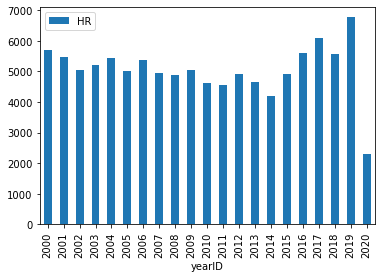

In [9]:
newBaseball.plot.bar(x='yearID', y='HR', rot=90)

It appears that there is a general upwards trend in homeruns hit each year with a steep decrease in 2020 because COVID-19 shortened the season dramatically. We expect to see all of the predictors values to reflect this decrease proportionately. In 2021, it is expected that the number of homeruns will return to the rising trend over the last decade. In the baseball community, this has become known as the "live ball era" because of the upwards trend in homeruns. 

Now that we have our data laid out in terms of total stats per year, we can continue.

In [10]:
mod = smf.ols(formula='HR ~ 1 + yearID + G + AB + R + H + Double + Triple + RBI + BB + SO + IBB', data = newBaseball)
#mod = smf.ols(formula='HR ~ 1 + yearID + G + AB + R + H + Double + Triple + RBI + SB + CS + BB + SO + IBB + HBP + SH + SF + GIDP', data = newBaseball)

In [11]:
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     HR   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.978
Method:                 Least Squares   F-statistic:                     80.16
Date:                Wed, 01 Dec 2021   Prob (F-statistic):           1.34e-07
Time:                        21:36:59   Log-Likelihood:                -122.74
No. Observations:                  21   AIC:                             269.5
Df Residuals:                       9   BIC:                             282.0
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -4.118e+04    6.5e+04     -0.633      0.542   -1.88e+05    1.06e+05
yearID        20.1018     32.200      0.624      0.548     -52.739      92.942
G              0.0190      0.133      0.143      0.890      -0.281       0.319
AB             0.0734      0.055      1.332      0.216      -0.051       0.198
R             -2.0101      1.632     -1.232      0.249      -5.703       1.682
H             -0.2088      0.151     -1.379      0.201      -0.551       0.134
Double        -1.2759      0.523     -2.438      0.038      -2.460      -0.092
Triple        -1.0013      0.977     -1.025      0.332      -3.211       1.208
RBI            2.9415      1.658      1.774      0.110      -0.809       6.692
BB            -0.2298      0.068     -3.366      0.008      -0.384      -0.075
SO            -0.0295      0.077     -0.383      0.711      -0.204       0.145
IBB            0.3511      0.480      0.731      0.483      -0.735       1.437
==============================================================================
Omnibus:                        0.213   Durbin-Watson:                   2.312
Prob(Omnibus):                  0.899   Jarque-Bera (JB):                0.189
Skew:                          -0.181   Prob(JB):                        0.910
Kurtosis:                       2.709   Cond. No.                     4.39e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.39e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

We decided to do a VIF analysis to determine collinearity in the predictors and found that many of the variables had a VIF score of above ten. This indicates a large amount of collinearity. We will not drop the predictors because of this but it is important to keep in mind as we head into our next step of subset selection. 

In [12]:
vif = pd.DataFrame()
vif['X'] = newBaseball.columns
vif['vif'] = [variance_inflation_factor(newBaseball.values, i) for i in range(len(newBaseball.columns))]
vif

,X,vif
0,yearID,2.501929e+02
1,G,1.006462e+05
2,AB,7.561195e+04
3,R,1.693378e+06
4,H,4.973675e+04
5,Double,3.774791e+04
6,Triple,1.041994e+03
7,HR,3.612559e+03
8,RBI,1.943725e+06
9,BB,2.880317e+03


## Subset Selection

After several attempts using different subset selection models, we've decided that with the number of different predictors we have Forward Subset Selection was the best one to use. With that, we are going to start by using the Forward Subset Selection algorithm to determine what the best subset (combination) of the predictors are. We will perform several iteratations of the process below to find the least complex model with the lowest BIC. This will not necessarily be the best model, however.

In [13]:
newBaseball.head()

,yearID,G,AB,R,H,Double,Triple,HR,RBI,BB,SO,IBB
0,2000,68815,167290,24971,45246,8901,952,5693,23735,18237,31356,1210
1,2001,68511,166234,23199,43879,8813,928,5458,22088,15806,32404,1384
2,2002,68345,165582,22408,43272,8700,921,5059,21332,16246,31394,1452
3,2003,68534,166737,22978,44057,8827,934,5207,21886,15889,30801,1316
4,2004,68882,167353,23376,44522,8919,898,5451,22248,16222,31828,1381


### Predictor 1

In [31]:
metric_store = [[],[]]
for i, combination in enumerate(combinations([0,1,2,3,4,5,6,8,9,10,11],1), 1):
    x_data = sm.add_constant(newBaseball.iloc[:,list(combination)])
    mod  = sm.OLS(newBaseball.HR, x_data).fit()
    metric_store[0].append(list(combination))
    metric_store[1].append(mod.bic)

In [32]:
metric_store

[[[0], [1], [2], [3], [4], [5], [6], [8], [9], [10], [11]],
 [347.4916460248037,
  328.75832736222566,
  330.8513857495648,
  320.9676636023511,
  331.61327398309015,
  331.2087569329838,
  337.30223324644874,
  320.384758876704,
  326.8882301962283,
  331.83330649178174,
  344.3158736946612]]

In [33]:
metric_store[0][np.argmin(metric_store[1])], np.min(metric_store[1])

([8], 320.384758876704)

### Predictor 2

In [34]:
metric_store = [[],[]]
for i, combination in enumerate(combinations([0,1,2,3,4,5,6,9,10,11],1), 1):
    x_data = sm.add_constant(newBaseball.iloc[:,[8] + list(combination)])
    mod  = sm.OLS(newBaseball.HR, x_data).fit()
    metric_store[0].append(list(combination))
    metric_store[1].append(mod.bic)

In [35]:
metric_store[0][np.argmin(metric_store[1])], np.min(metric_store[1])

([11], 299.38715720274564)

### Predictor 3

In [36]:
metric_store = [[],[]]
for i, combination in enumerate(combinations([0,1,2,3,4,5,6,9,10],1), 1):
    x_data = sm.add_constant(newBaseball.iloc[:,[8,11] + list(combination)])
    mod  = sm.OLS(newBaseball.HR, x_data).fit()
    metric_store[0].append(list(combination))
    metric_store[1].append(mod.bic)

In [37]:
metric_store[0][np.argmin(metric_store[1])], np.min(metric_store[1])

([3], 296.4574182294543)

### Predictor 4

In [38]:
metric_store = [[],[]]
for i, combination in enumerate(combinations([0,1,2,4,5,6,9,10],1), 1):
    x_data = sm.add_constant(newBaseball.iloc[:,[8,11,3] + list(combination)])
    mod  = sm.OLS(newBaseball.HR, x_data).fit()
    metric_store[0].append(list(combination))
    metric_store[1].append(mod.bic)

In [39]:
metric_store[0][np.argmin(metric_store[1])], np.min(metric_store[1])

([5], 295.7428512285722)

### Predictor 5

In [42]:
metric_store = [[],[]]
for i, combination in enumerate(combinations([0,1,2,4,6,9,10],1), 1):
    x_data = sm.add_constant(newBaseball.iloc[:,[8,11,3,5] + list(combination)])
    mod  = sm.OLS(newBaseball.HR, x_data).fit()
    metric_store[0].append(list(combination))
    metric_store[1].append(mod.bic)

In [43]:
metric_store[0][np.argmin(metric_store[1])], np.min(metric_store[1])

([10], 282.99222860080926)

In [44]:
metric_store = [[],[]]
for i, combination in enumerate(combinations([0,1,2,4,6,9],1), 1):
    x_data = sm.add_constant(newBaseball.iloc[:,[8,11,3,5,10] + list(combination)])
    mod  = sm.OLS(newBaseball.HR, x_data).fit()
    metric_store[0].append(list(combination))
    metric_store[1].append(mod.bic)

In [45]:
metric_store[0][np.argmin(metric_store[1])], np.min(metric_store[1])

([9], 275.55217572725644)

In [46]:
metric_store = [[],[]]
for i, combination in enumerate(combinations([0,1,2,4,6],1), 1):
    x_data = sm.add_constant(newBaseball.iloc[:,[8,11,3,5,10,9] + list(combination)])
    mod  = sm.OLS(newBaseball.HR, x_data).fit()
    metric_store[0].append(list(combination))
    metric_store[1].append(mod.bic)

In [47]:
metric_store[0][np.argmin(metric_store[1])], np.min(metric_store[1])

([6], 276.60603078600235)

8,11,3,5,10,9

In [49]:
newBaseball.head()

,yearID,G,AB,R,H,Double,Triple,HR,RBI,BB,SO,IBB
0,2000,68815,167290,24971,45246,8901,952,5693,23735,18237,31356,1210
1,2001,68511,166234,23199,43879,8813,928,5458,22088,15806,32404,1384
2,2002,68345,165582,22408,43272,8700,921,5059,21332,16246,31394,1452
3,2003,68534,166737,22978,44057,8827,934,5207,21886,15889,30801,1316
4,2004,68882,167353,23376,44522,8919,898,5451,22248,16222,31828,1381


R, Double, RBI, BB, SO, and IBB appears to be our best subset of predictors to use for predicting the number of homeruns.

Here, we stop since the BIC from Predictor 5 is higher than the BIC of Predictor 4. So our best subset is [8,10,15,16], or RBIs, CS, SH, and SF.

In [ ]:
mod = smf.ols(formula='HR ~ 1 + RBI + CS + SH + SF', data = newBaseball)
res = mod.fit()
res.summary()

In [ ]:
plt.figure(dpi = 150)
plt.plot(newBaseball['RBI'], newBaseball['HR'], '.', markersize=10, markeredgecolor="black", color="goldenrod")
plt.plot(newBaseball['CS'], newBaseball['HR'], '.', markersize=10, markeredgecolor="black", color="red")
plt.plot(newBaseball['SH'], newBaseball['HR'], '.', markersize=10, markeredgecolor="black", color="green")
plt.plot(newBaseball['SF'], newBaseball['HR'], '.', markersize=10, markeredgecolor="black", color="blue")
plt.ylabel("Home Runs")
plt.grid()
plt.show()